In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words as nltk_words
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from langdetect import detect
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import random

In [2]:
df = pd.read_csv('database.csv')

In [3]:
df.head(5)

Business reviewed Reviewer Username Review date      Visit Date  \
0  Makedonia Palace   stargateTelAviv    Apr 2023        May 2022   
1  Makedonia Palace       ailLondon15    Feb 2023   February 2023   
2  Makedonia Palace  Seasondtraveller    Jan 2023    January 2023   
3  Makedonia Palace         Ioannis K    Jan 2023    January 2023   
4  Makedonia Palace           Derek C    Dec 2022  September 2022   

                                        Review Title  \
0                                   Jewel of a hotel   
1                A lovely hotel with beautiful views   
2  Great location, excellent breakfast, comfortab...   
3  3 or 4 stars service experience, paid for 5* h...   
4                                   Simply The Best!   

                                         Review Text Review Ratings  
0  We were 60 ladies  on a LOJI trip and meeting ...      bubble_50  
1  I staying at this hotel while in business in T...      bubble_50  
2  The hotel is in an ugly building but is luxuri...      bubble_40  
3  It was a pleasant stay overall, but this legen...      bubble_30  
4  I have stayed in this hotel many times with my...      bubble_50

In [4]:
len(df)

29498

In [5]:
len(df[df.duplicated()])

20720

In [6]:
duplicated_df = df[df.duplicated()]
duplicated_df['Business reviewed'].value_counts()

S Hotel Thessaloniki    20720
Name: Business reviewed, dtype: int64

# Preprocessing

In [7]:
# Remove identical rows
df = df.drop_duplicates()

In [8]:
# Remove rows where the year is missing
pattern = r'\d'

def has_less_than_4_digits(string):
    matches = re.findall(pattern, string)
    return len(matches) < 4

df = df[~df['Review date'].apply(has_less_than_4_digits)]

# Make the dtype of the date column 
df['Review date'] = pd.to_datetime(df['Review date'], format='%b %Y')

In [9]:
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()


# Define the custom list of words to preserve
preserve_words = {'isn', 'no', 'none', 'doesn', 'not', 'wasn', 'aint', 'aint', 'arent', 
                  'cannot', 'couldn', 'didn', 'hadn', 'hasnt', 'haven', 'mustn', 'shouldn', 
                  'wasn', 'weren', 'wont', 'wouldn', 'haven\'t', 'mustn\'t', 'shouldn\'t', 
                  'wasn\'t', 'weren\'t', 'won\'t', 'wouldn\'t', 'couldn\'t', 'didn\'t', 
                  'hadn\'t', 'hasn\'t','couldn\'t', 'didn\'t', 'arent\'t', 'wasn\'t', 'isn\'t'}

final_stop_words = set([word for word in stop_words if word not in preserve_words])


# Remove stopwords, non-alphanumerics, numbers, punctuation and lowercase the words
df['clean_reviews'] = df['Review Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) \
                                                                  for word in word_tokenize(x) if word.isalnum() \
                                                                  and not word.isdigit() and word.isalpha() \
                                                                  and word.lower() not in final_stop_words]))

# Remove non-english reviews
df['language'] = df['clean_reviews'].apply(lambda x: detect(x))
df = df[df['language'] == 'en']

# Final DataFrame

In [10]:
df.head(5)

Business reviewed Reviewer Username Review date      Visit Date  \
0  Makedonia Palace   stargateTelAviv  2023-04-01        May 2022   
1  Makedonia Palace       ailLondon15  2023-02-01   February 2023   
2  Makedonia Palace  Seasondtraveller  2023-01-01    January 2023   
3  Makedonia Palace         Ioannis K  2023-01-01    January 2023   
4  Makedonia Palace           Derek C  2022-12-01  September 2022   

                                        Review Title  \
0                                   Jewel of a hotel   
1                A lovely hotel with beautiful views   
2  Great location, excellent breakfast, comfortab...   
3  3 or 4 stars service experience, paid for 5* h...   
4                                   Simply The Best!   

                                         Review Text Review Ratings  \
0  We were 60 ladies  on a LOJI trip and meeting ...      bubble_50   
1  I staying at this hotel while in business in T...      bubble_50   
2  The hotel is in an ugly building but is luxuri...      bubble_40   
3  It was a pleasant stay overall, but this legen...      bubble_30   
4  I have stayed in this hotel many times with my...      bubble_50   

                                       clean_reviews language  
0  lady loji trip meeting israel hotel lovely vie...       en  
1  staying hotel business thessaloniki paid bit e...       en  
2  hotel ugly building luxurious clean inside fac...       en  
3  pleasant stay overall legendary hotel term pri...       en  
4  stayed hotel many time life partner whenever v...       en

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8701 entries, 0 to 29497
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Business reviewed  8701 non-null   object        
 1   Reviewer Username  8701 non-null   object        
 2   Review date        8701 non-null   datetime64[ns]
 3   Visit Date         8701 non-null   object        
 4   Review Title       8701 non-null   object        
 5   Review Text        8701 non-null   object        
 6   Review Ratings     8701 non-null   object        
 7   clean_reviews      8701 non-null   object        
 8   language           8701 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 679.8+ KB


# Question 1

Visualize the number of monthly reviews over time over all locations. Which was the month with the most reviews? Is there any seasonality in the volume of reviews?

In [12]:
review_dates_df = pd.DataFrame(df['Review date'].value_counts(dropna=False)) \
    .reset_index(drop=False) \
    .rename(columns={'Review date': 'Reviews count', 'index': 'Date'})

In [13]:
review_dates_df.sort_values(by='Date', inplace=True)

In [14]:
fig = px.line(review_dates_df, x="Date", y="Reviews count", title='Reviews count over time')
fig.update_traces(line_color='darkgreen')
fig.update_layout(
    xaxis=dict(title='Date'),
    yaxis=dict(title='Reviews count'),
    plot_bgcolor='white',
    title_font=dict(size=20),
    legend=dict(font=dict(size=12)),
    margin=dict(l=50, r=50, t=80, b=50)
)
fig.show()


In [15]:
review_dates_df = pd.DataFrame(df['Review date'].value_counts(dropna=False)).reset_index(drop=False).rename(
    columns={'Review date': 'Reviews count', 'index': 'Date'})

# Convert 'Date' column to datetime type
review_dates_df['Date'] = pd.to_datetime(review_dates_df['Date'])

# Group by month and calculate the sum of reviews count
review_dates_df = review_dates_df.groupby(review_dates_df['Date'].dt.month)['Reviews count'].sum().reset_index()

# Rename the month values to month names
review_dates_df['Date'] = pd.to_datetime(review_dates_df['Date'], format='%m').dt.month_name().str.slice(stop=3)

# Specify the order of the months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
review_dates_df['Date'] = pd.Categorical(review_dates_df['Date'], categories=month_order, ordered=True)

review_dates_df.sort_values(by='Date', inplace=True)

fig = px.line(review_dates_df, x="Date", y="Reviews count", title='Reviews count per month')


fig.update_traces(line_color='darkgreen')  
fig.update_layout(
    xaxis=dict(title='Month'), 
    yaxis=dict(title='Reviews count'), 
    plot_bgcolor='white',  
    title_font=dict(size=20),  
    legend=dict(font=dict(size=12)), 
    margin=dict(l=50, r=50, t=80, b=50),  
)

fig.show()

# Question 2

Which are the top-10 rated and the bottom-10 rated locations? Consider a combination of the number of ratings for a location and the rating itself for validity

In [16]:
hotel_ratings_df = df[['Business reviewed', 'Review Ratings']].copy()

In [17]:
hotel_ratings_df['Rating (numerical)'] = hotel_ratings_df['Review Ratings'].map({'bubble_10': 1, 
                                                                                 'bubble_20': 2,
                                                                                 'bubble_30': 3,
                                                                                 'bubble_40': 4,
                                                                                 'bubble_50': 5,})

In [18]:
# Calculate the review counts per hotel
review_counts = pd.DataFrame(hotel_ratings_df.groupby(['Business reviewed'])['Rating (numerical)'].count()) \
    .reset_index(drop=False) \
    .rename(columns={'Rating (numerical)': 'Reviews count'})

# Calculate the average rating per hotel
average_rating = pd.DataFrame(hotel_ratings_df.groupby(['Business reviewed'])['Rating (numerical)'].mean()) \
    .reset_index(drop=False) \
    .rename(columns={'Rating (numerical)': 'Average rating'})

# Merge the review counts and average rating dataframes
hotel_avg_ratings_df = review_counts.merge(average_rating, on='Business reviewed', how='left')

weight_average_rating = 2  # Weight for average rating
weight_review_count = 0.1 # Weight for review count

hotel_avg_ratings_df['Weighted Average Rating'] = (hotel_avg_ratings_df['Average rating'] * weight_average_rating) + \
                                                  (hotel_avg_ratings_df['Reviews count'].apply(math.sqrt) * 
                                                   weight_review_count)

In [19]:
hotel_avg_ratings_df.sort_values('Weighted Average Rating', ascending=False).head(10)

Business reviewed  Reviews count  Average rating  \
26                The Met Hotel           1032        4.642442   
25                The Excelsior            715        4.801399   
12  Electra Palace Thessaloniki           1130        4.381416   
10          Daios Luxury Living            565        4.692035   
15             Makedonia Palace            804        4.442786   
24                  The Caravan            297        4.932660   
27   The Modernist Thessaloniki            181        4.895028   
6    Blue Bottle Boutique Hotel            257        4.758755   
29                 Vanoro Hotel             95        4.947368   
9            Colors Urban Hotel            230        4.595652   

    Weighted Average Rating  
26                12.497359  
25                12.276746  
12                12.124379  
10                11.761044  
15                11.721062  
24                11.588689  
27                11.135418  
6                 11.120632  
29                10.869416  
9                 10.707879

In [20]:
hotel_avg_ratings_df.sort_values('Weighted Average Rating', ascending=True).head(10)

Business reviewed  Reviews count  Average rating  \
1                 Amalia Hotel             42        3.238095   
7    Capsis Hotel Thessaloniki             48        3.541667   
21               Rotonda Hotel            138        3.442029   
0                 Aegeon Hotel            123        3.560976   
3       Andromeda Thessaloniki            127        3.763780   
11  Egnatia Palace Hotel & Spa            174        4.126437   
13          Grand Hotel Palace            305        3.940984   
23          Stay Hybrid Hostel             52        4.480769   
28                Urban Donkey             15        4.666667   
19                  Park Hotel            179        4.256983   

    Weighted Average Rating  
1                  7.124265  
7                  7.776154  
21                 8.058792  
0                  8.231005  
3                  8.654502  
11                 9.571964  
13                 9.628392  
23                 9.682649  
28                 9.720632  
19                 9.851875

# Question 3

Which locations have the highest increase or decrease in rating over the years? Consider calculating the yearly average and percentage change per location.

In [21]:
inc_dec_rating_df = df[['Business reviewed', 'Review date', 'Review Ratings']].copy()

In [22]:
inc_dec_rating_df['Rating (numerical)'] = inc_dec_rating_df['Review Ratings'].map({'bubble_10': 1, 
                                                                                 'bubble_20': 2,
                                                                                 'bubble_30': 3,
                                                                                 'bubble_40': 4,
                                                                                 'bubble_50': 5,}) 
inc_dec_rating_df.drop(columns=['Review Ratings'], inplace=True)
inc_dec_rating_df['Year'] = inc_dec_rating_df['Review date'].dt.year

In [23]:
# Convert 'Year' column to datetime type
inc_dec_rating_df['Year'] = pd.to_datetime(inc_dec_rating_df['Year'], format='%Y')

# Calculate the average rating for each hotel
avg_rating_df = inc_dec_rating_df.groupby(['Business reviewed', pd.Grouper(key='Year', freq='1Y')])['Rating (numerical)']\
    .mean().reset_index()

# Calculate the percentage change in rating from year to year
avg_rating_df['Rating Change (%)'] = avg_rating_df.groupby('Business reviewed')['Rating (numerical)'].pct_change() * 100

# Group by hotel and calculate the overall change in rating
result_df = avg_rating_df.groupby('Business reviewed')['Rating Change (%)'].sum().reset_index()
result_df['Change Type'] = result_df['Rating Change (%)'].apply(lambda x: 'Increase' if x > 0 else 'Decrease')


display(result_df.sort_values('Rating Change (%)', ascending=False).head(5))
display(result_df.sort_values('Rating Change (%)', ascending=False).tail(5))

Business reviewed  Rating Change (%) Change Type
3   Andromeda Thessaloniki         293.695137    Increase
5            Astoria Hotel         252.070425    Increase
23      Stay Hybrid Hostel         228.904745    Increase
21           Rotonda Hotel         117.488841    Increase
19              Park Hotel          54.560201    Increase

Business reviewed  Rating Change (%) Change Type
7     Capsis Hotel Thessaloniki         -12.839506    Decrease
10          Daios Luxury Living         -14.715652    Decrease
18                  ONOMA Hotel         -17.869048    Decrease
26                The Met Hotel         -20.833595    Decrease
2   Anatolia Hotel Thessaloniki         -61.825911    Decrease

# Question 4

Visualize the most common words, bi-grams, and tri-grams across all reviews through a bar chart or word cloud. Also, visualize the most common words, bi-grams, and tri-grams in 5-star versus 1-star reviews.

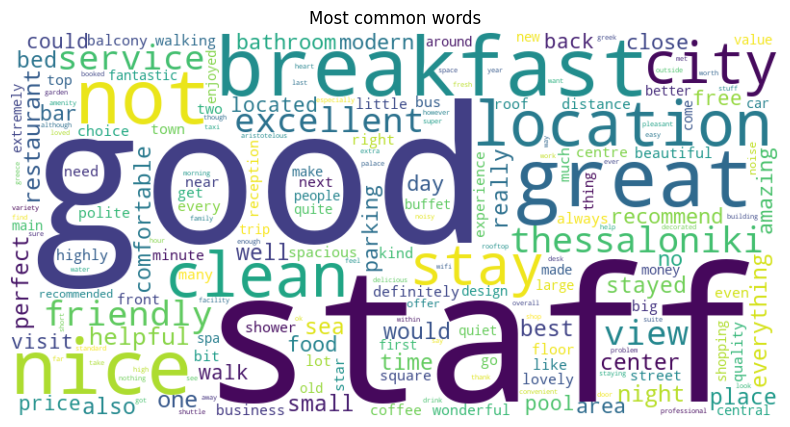

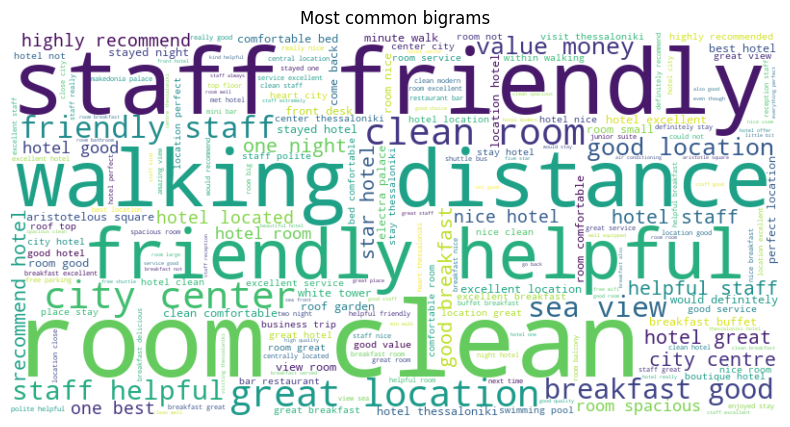

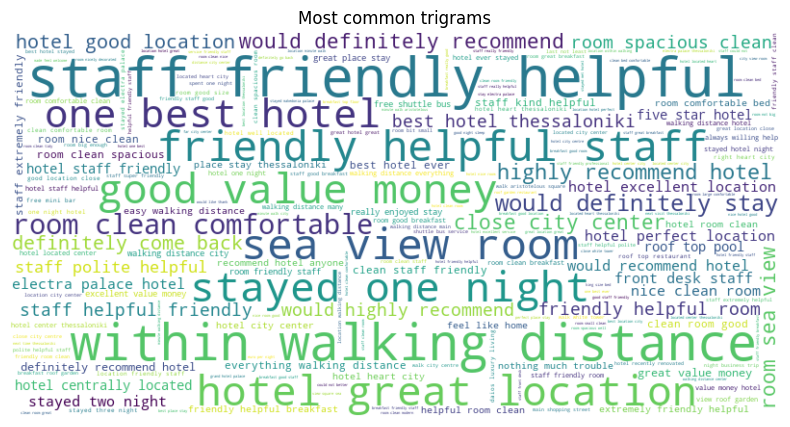

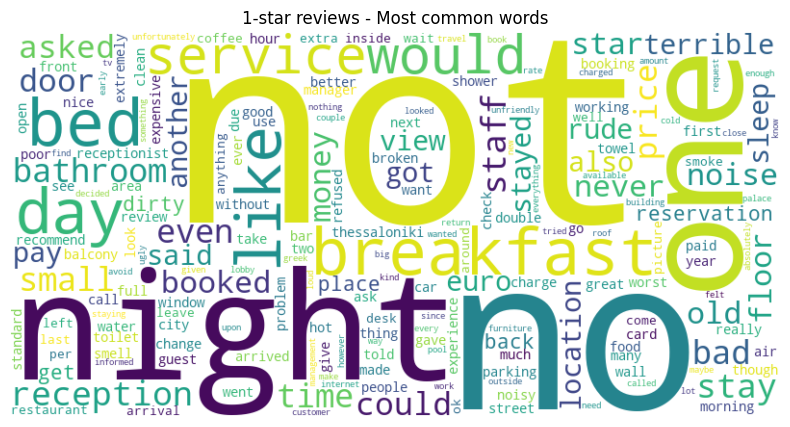

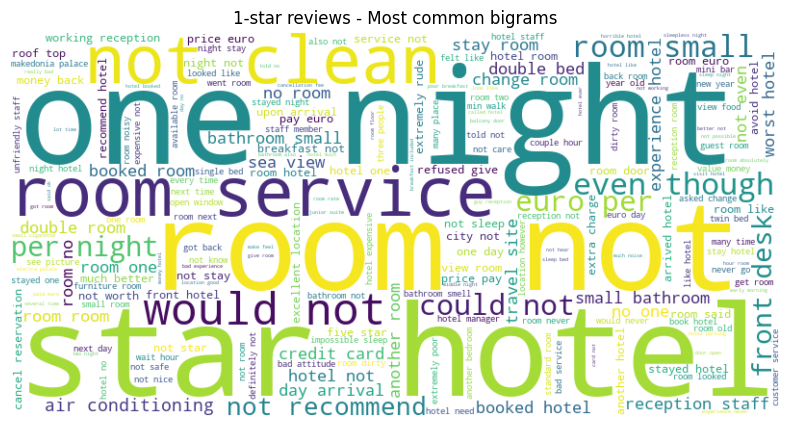

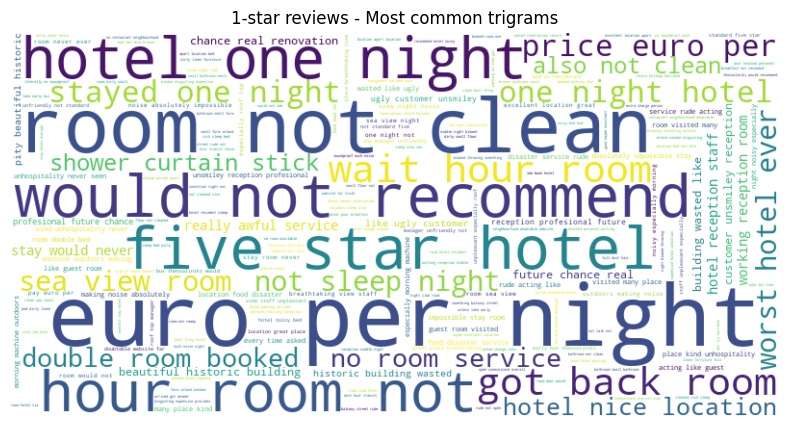

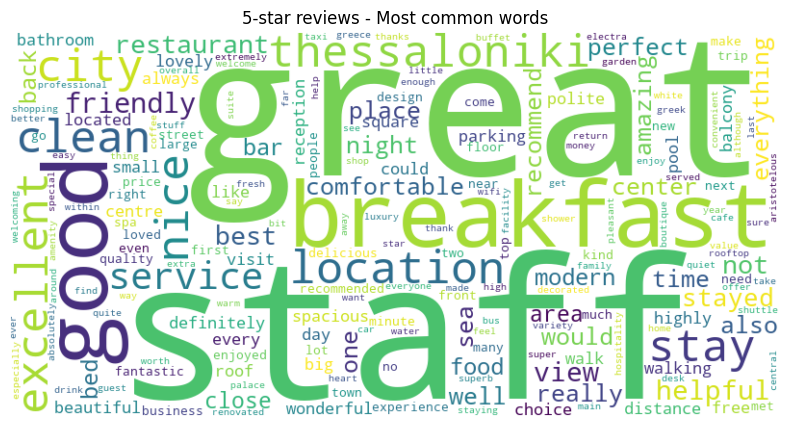

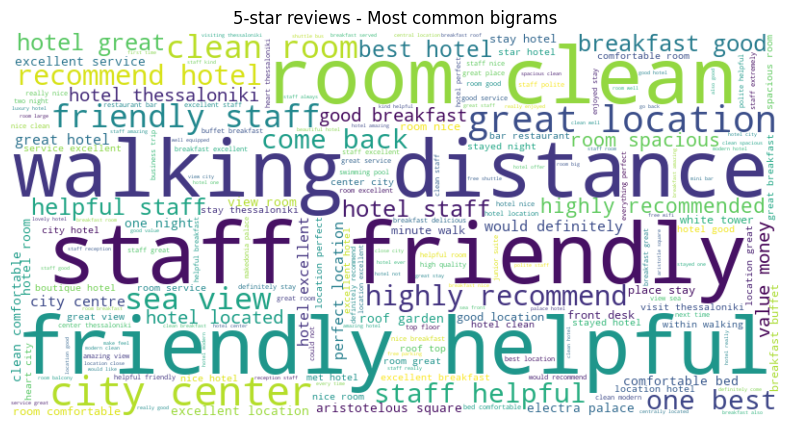

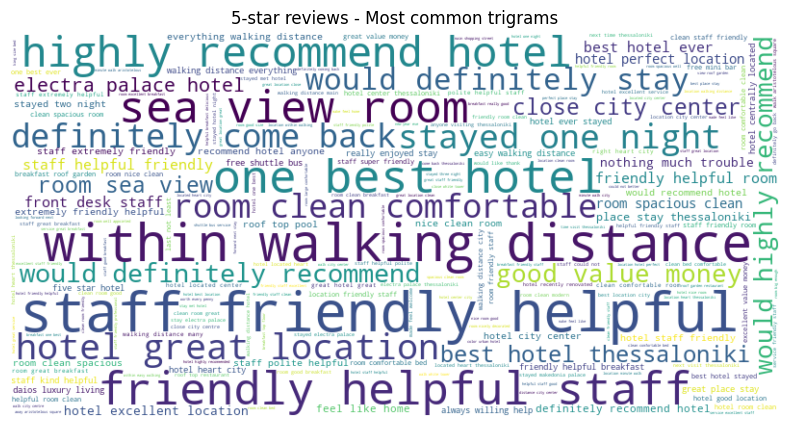

In [24]:
def create_word_cloud(df, mode, title, rating=None):
    word_counts_dict = tfidf_counter(df, mode, title, rating)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def tfidf_counter(df, mode, title, rating=None):
    if rating == 1:
        df = df[df['Review Ratings'] == 'bubble_10']
    elif rating == 5:
        df = df[df['Review Ratings'] == 'bubble_50']
    
    if mode == 'words':
        tfidf_vectorizer = TfidfVectorizer(max_df=0.7)
        tfidf_words = tfidf_vectorizer.fit_transform(df['clean_reviews'])
    elif mode == 'bigrams':
        tfidf_vectorizer = TfidfVectorizer(max_df=0.7, ngram_range=(2, 2))
        tfidf_words = tfidf_vectorizer.fit_transform(df['clean_reviews'])
    elif mode == 'trigrams':
        tfidf_vectorizer = TfidfVectorizer(max_df=0.7, ngram_range=(3, 3))
        tfidf_words = tfidf_vectorizer.fit_transform(df['clean_reviews'])
    
    words = tfidf_vectorizer.get_feature_names_out()
    word_counts = tfidf_words.toarray().sum(axis=0)
    word_counts_dict = dict(zip(words, word_counts))
    
    return word_counts_dict

create_word_cloud(df, 'words', 'Most common words')
create_word_cloud(df, 'bigrams', 'Most common bigrams')
create_word_cloud(df, 'trigrams', 'Most common trigrams')
create_word_cloud(df, 'words', '1-star reviews - Most common words', 1)
create_word_cloud(df, 'bigrams', '1-star reviews - Most common bigrams', 1)
create_word_cloud(df, 'trigrams', '1-star reviews - Most common trigrams', 1)
create_word_cloud(df, 'words', '5-star reviews - Most common words', 5)
create_word_cloud(df, 'bigrams', '5-star reviews - Most common bigrams', 5)
create_word_cloud(df, 'trigrams', '5-star reviews - Most common trigrams', 5)

# Question 5

Which are the 10 fastest growing and the 10 fastest shrinking words (based on usage frequency) in TripAdvisor reviews over time?

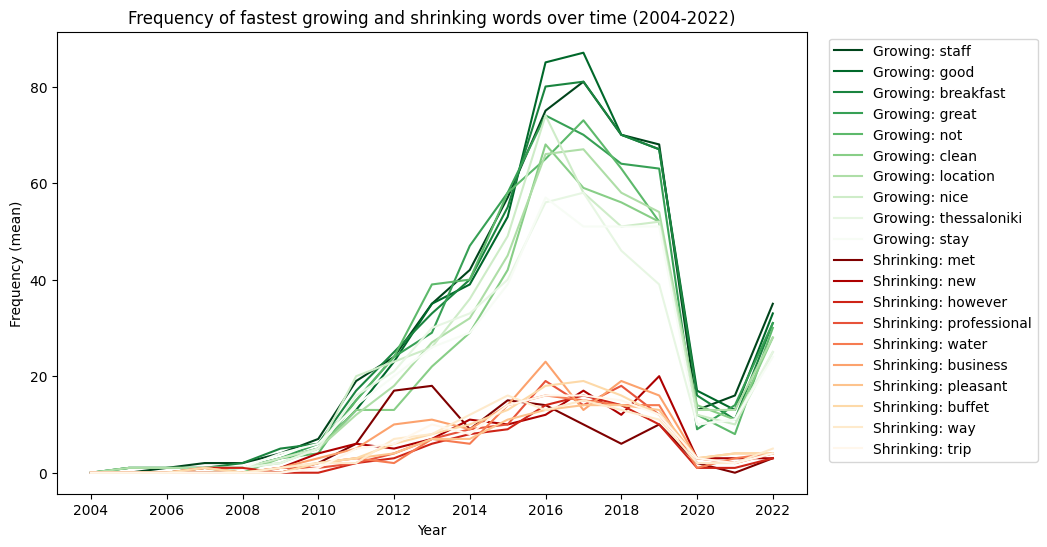

In [25]:
df['Year'] = pd.DatetimeIndex(df['Review date']).year

# Keep the reviews before 2023 (because the 2023 season hasn't even peaked yet)
df_threshold_year = df[(df['Year'] < 2023)]


# Create a document-term matrix using TfidfVectorizer
cv = TfidfVectorizer(min_df=400, max_df=0.6)
dtm = cv.fit_transform(df_threshold_year['clean_reviews'])

dtm_df = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())

# Group by year and calculate the word frequencies
word_freq_by_year = dtm_df.groupby(df_threshold_year['Year']).sum()

# Calculate the frequency differences between consecutive years for each word
freq_diff = word_freq_by_year.diff()

# Get the fastest growing and shrinking words
fastest_growing_words = freq_diff.mean().sort_values(ascending=False)[:10].index.tolist()
fastest_shrinking_words = freq_diff.mean().sort_values()[:10].index.tolist()

# Convert the 'Year' column in word_freq_by_year to integers
word_freq_by_year = word_freq_by_year.astype(int)

growing_palette = plt.cm.Greens(np.linspace(1, 0, len(fastest_growing_words))) 
shrinking_palette = plt.cm.OrRd(np.linspace(1, 0, len(fastest_shrinking_words)))

plt.figure(figsize=(12, 6))

for i, word in enumerate(fastest_growing_words):
    plt.plot(word_freq_by_year.index, word_freq_by_year[word], label='Growing: ' + word, color=growing_palette[i])

for i, word in enumerate(fastest_shrinking_words):
    plt.plot(word_freq_by_year.index, word_freq_by_year[word], label='Shrinking: ' + word, color=shrinking_palette[i])

plt.xlabel('Year')
plt.ylabel('Frequency (mean)')
plt.title('Frequency of fastest growing and shrinking words over time (2004-2022)')

plt.xticks(np.arange(min(word_freq_by_year.index), max(word_freq_by_year.index)+1, 2))

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.subplots_adjust(right=0.75)  

plt.show()

# Question 6

Explore and visualize emerging topics from all the user reviews across time.

In [26]:
vectorizer = TfidfVectorizer(min_df=200, max_df=0.8)
X = vectorizer.fit_transform(df['clean_reviews'])

svd = TruncatedSVD(n_components=4)
svd.fit(X)
topics = svd.components_

num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(topics):
    top_words_indices = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic {i+1}: {' '.join(top_words)}")

Topic 1: hotel room good staff breakfast great not nice location clean
Topic 2: not good room small no bathroom shower night street parking
Topic 3: good nice clean location center friendly helpful close near parking
Topic 4: view sea great roof square pool balcony restaurant floor room


* Topic 1: Generic
* Topic 2: Ammenities/Indoor spaces
* Topic 3: Transportation
* Topic 4: Ammenities/Outdoor spaces

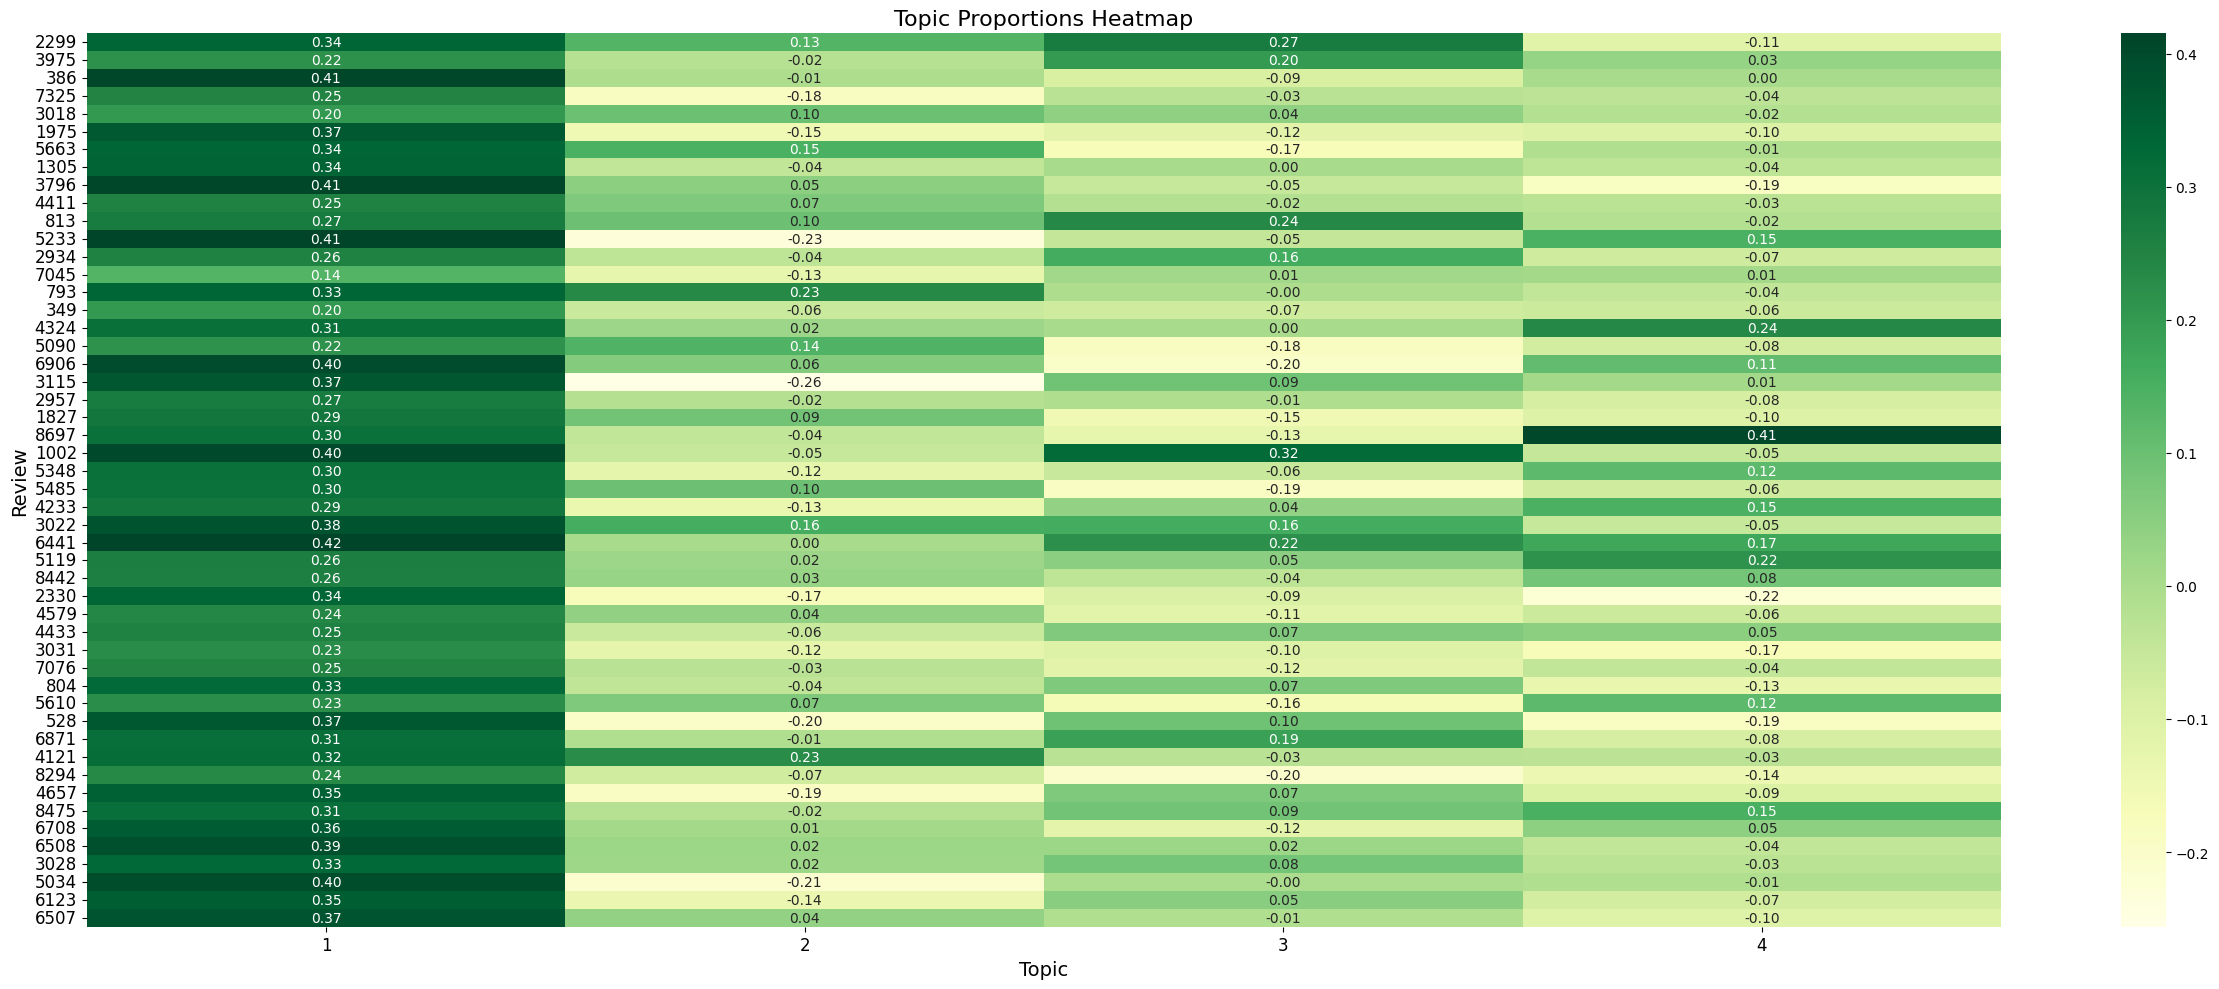

In [27]:
topic_proportions = svd.transform(X)

dominant_topics = np.argmax(topic_proportions, axis=1)
sorted_indices = np.argsort(dominant_topics)
sorted_topic_proportions = topic_proportions[sorted_indices]

num_documents = 50  
random.seed(22)
random_indices = random.sample(range(len(df)), num_documents)
subset_topic_proportions = sorted_topic_proportions[random_indices]

plt.figure(figsize=(25, 10))
sns.heatmap(subset_topic_proportions, cmap='YlGn', annot=True, fmt=".2f", cbar=True)

num_topics = len(topics)
plt.xticks(np.arange(num_topics) + 0.5, range(1, num_topics + 1), fontsize=12)
plt.yticks(np.arange(num_documents) + 0.5, random_indices, fontsize=12)
plt.ylabel('Review', fontsize=14)

plt.xlabel('Topic', fontsize=14)
plt.title('Topic Proportions Heatmap', fontsize=16)

plt.tight_layout()

plt.show()

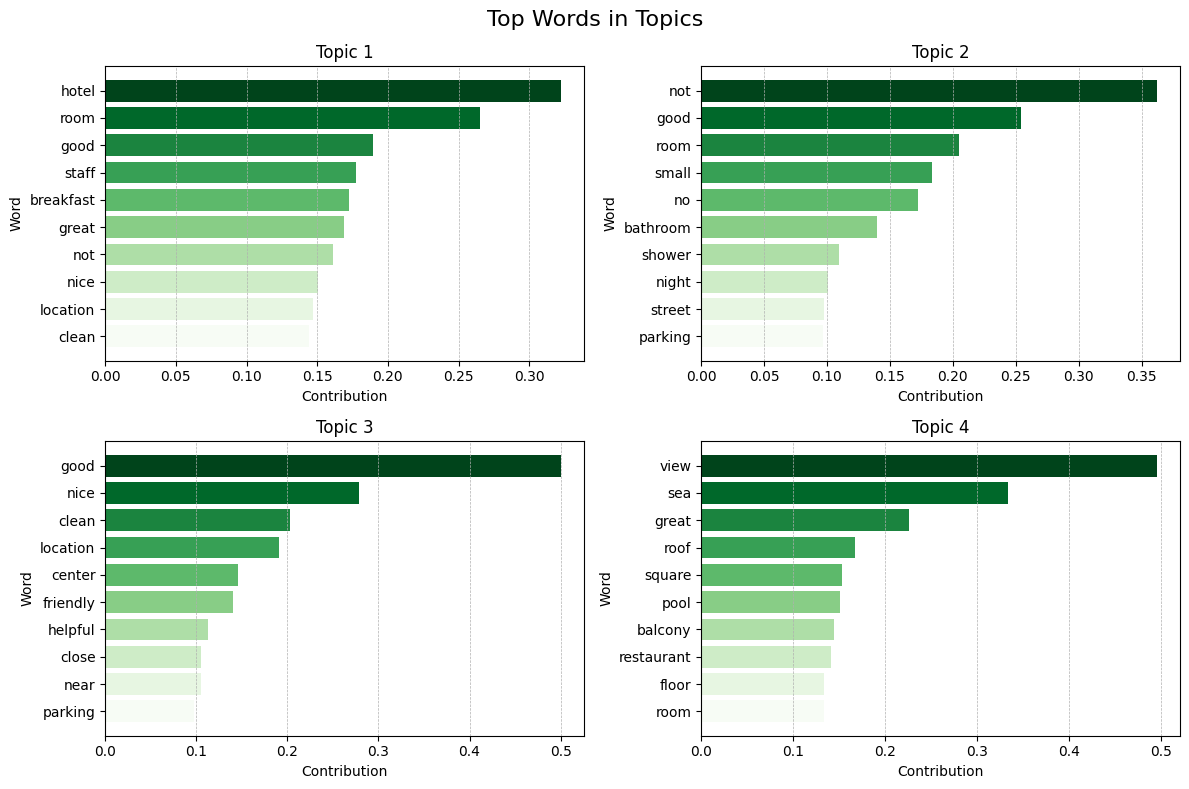

In [28]:
num_top_words = 10
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

fig.suptitle("Top Words in Topics", fontsize=16)

color_palette = plt.cm.get_cmap("Greens", num_top_words)

for i, topic in enumerate(topics):
    top_words_indices = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    top_word_contributions = [topic[i] for i in top_words_indices]

    top_words = top_words[::-1]
    top_word_contributions = top_word_contributions[::-1]

    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.barh(top_words, top_word_contributions, color=color_palette(np.arange(num_top_words)))
    ax.set_xlabel("Contribution")
    ax.set_ylabel("Word")
    ax.set_title(f"Topic {i+1}")
    ax.grid(axis='x', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
